# QLoRA Test: Target Modules Comparison - Qwen3-4B-Thinking

Compares different `target_modules` configurations to understand which layers to apply LoRA adapters.

**Configurations tested:**
- **qv_only**: ["q_proj", "v_proj"] - Minimal (query + value attention)
- **attention_only**: ["q_proj", "k_proj", "v_proj", "o_proj"] - All attention layers
- **mlp_only**: ["gate_proj", "up_proj", "down_proj"] - MLP/FFN layers only
- **all_linear**: All 7 modules - Maximum capacity

**Measurements:**
- Trainable parameters per configuration
- Final training loss
- Inference quality (reasoning preservation)

**Key insight:** Different target modules affect different model capabilities:
- Attention layers: Representation adaptation
- MLP layers: Knowledge injection/modification

**Important:** This notebook includes a kernel shutdown cell at the end to release all GPU memory.

In [1]:
# Environment Setup
import os
from dotenv import load_dotenv
load_dotenv()

# CRITICAL: Import unsloth FIRST for proper TRL patching
import unsloth
from unsloth import FastLanguageModel, is_bf16_supported

import torch
import gc

# Environment summary
gpu = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
print(f"Environment: unsloth {unsloth.__version__}, PyTorch {torch.__version__}, {gpu}")
print(f"HF_TOKEN loaded: {'Yes' if os.environ.get('HF_TOKEN') else 'No'}")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/opt/pixi/.pixi/envs/default/lib/python3.13/site-packages/trl/__init__.py:203: UserWarning: TRL currently supports vLLM versions: 0.10.2, 0.11.0, 0.11.1, 0.11.2. You have version 0.14.0rc1.dev201+gadcf682fc.cu130 installed. We recommend installing a supported version to avoid compatibility issues.
  if is_vllm_available():


🦥 Unsloth Zoo will now patch everything to make training faster!


Environment: unsloth 2025.12.10, PyTorch 2.9.1+cu130, NVIDIA GeForce RTX 4080 SUPER
HF_TOKEN loaded: Yes


In [2]:
# Benchmark Helper Functions
import subprocess

def measure_gpu_memory():
    """Measure current GPU memory usage in MB using nvidia-smi"""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader,nounits'],
            capture_output=True, text=True
        )
        return int(result.stdout.strip().split('\n')[0])
    except:
        return 0

def count_parameters(model):
    """Count trainable vs total parameters"""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return {
        "trainable": trainable,
        "total": total,
        "pct": 100 * trainable / total
    }

def cleanup_memory():
    """Force garbage collection and clear CUDA cache"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

print("Benchmark functions defined.")
print(f"Initial GPU memory: {measure_gpu_memory()} MB")

Benchmark functions defined.
Initial GPU memory: 1800 MB


In [3]:
# Create minimal synthetic instruction dataset with thinking content (5 samples)
from datasets import Dataset

synthetic_data = [
    {
        "instruction": "What is machine learning?",
        "thinking": "What is the user asking here? They want to understand machine learning. What are the key concepts I should cover? It's a subset of AI... and it involves learning from data. How should I keep this accessible? Short and clear definition.",
        "response": "Machine learning is a subset of artificial intelligence where computers learn patterns from data."
    },
    {
        "instruction": "Explain Python in one sentence.",
        "thinking": "One sentence only - what's most important about Python? Its readability and versatility are the defining features. How do I capture both in one sentence?",
        "response": "Python is a high-level programming language known for its readability and versatility."
    },
    {
        "instruction": "What is a neural network?",
        "thinking": "How do I explain neural networks simply? What's the core concept? They're inspired by biological neurons... they process information in layers. Should I mention deep learning? Maybe keep it basic for now.",
        "response": "A neural network is a computational model inspired by biological neurons that processes information through connected layers."
    },
    {
        "instruction": "Define supervised learning.",
        "thinking": "What makes supervised learning 'supervised'? It's the labels! The data has known outputs. How do I explain this clearly? Focus on the training process with labeled data.",
        "response": "Supervised learning is training a model on labeled data to predict outcomes for new inputs."
    },
    {
        "instruction": "What is gradient descent?",
        "thinking": "This is a bit technical. What's the intuition behind gradient descent? It's like walking downhill to find the lowest point. The gradient tells us which direction is 'down'. Keep it conceptual.",
        "response": "Gradient descent is an optimization algorithm that minimizes loss by iteratively adjusting parameters in the direction of steepest descent."
    },
]

print(f"Synthetic dataset prepared: {len(synthetic_data)} samples")

Synthetic dataset prepared: 5 samples


In [4]:
# Target Module Configurations

TARGET_CONFIGS = {
    "qv_only": {
        "modules": ["q_proj", "v_proj"],
        "description": "Query + Value only (minimal)",
    },
    "attention_only": {
        "modules": ["q_proj", "k_proj", "v_proj", "o_proj"],
        "description": "All attention layers",
    },
    "mlp_only": {
        "modules": ["gate_proj", "up_proj", "down_proj"],
        "description": "MLP/FFN layers only",
    },
    "all_linear": {
        "modules": ["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
        "description": "All linear layers (maximum)",
    },
}

print("Target module configurations:")
for name, config in TARGET_CONFIGS.items():
    print(f"  - {name}: {config['description']}")
    print(f"    Modules: {config['modules']}")

Target module configurations:
  - qv_only: Query + Value only (minimal)
    Modules: ['q_proj', 'v_proj']
  - attention_only: All attention layers
    Modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
  - mlp_only: MLP/FFN layers only
    Modules: ['gate_proj', 'up_proj', 'down_proj']
  - all_linear: All linear layers (maximum)
    Modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']


In [5]:
# Target Modules Comparison Loop
from trl import SFTTrainer, SFTConfig

MODEL_NAME = "unsloth/Qwen3-4B-Thinking-2507-unsloth-bnb-4bit"
FIXED_RANK = 16
results = []

for config_name, config in TARGET_CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"Testing: {config['description']}")
    print(f"Modules: {config['modules']}")
    print(f"{'='*60}")
    
    # Cleanup and measure baseline
    cleanup_memory()
    
    # Load fresh model
    print(f"Loading model...")
    model, tokenizer = FastLanguageModel.from_pretrained(
        MODEL_NAME,
        max_seq_length=512,
        load_in_4bit=True,
        dtype=None,
    )
    
    # Apply LoRA with current target modules
    print(f"Applying LoRA with r={FIXED_RANK}...")
    model = FastLanguageModel.get_peft_model(
        model,
        r=FIXED_RANK,
        lora_alpha=FIXED_RANK,
        lora_dropout=0,
        target_modules=config["modules"],
        bias="none",
        use_gradient_checkpointing="unsloth",
        random_state=42,
    )
    
    params = count_parameters(model)
    print(f"Trainable: {params['trainable']:,} ({params['pct']:.2f}%)")
    
    # Format dataset
    def format_conversation(sample):
        assistant_content = f"<think>\n{sample['thinking']}\n</think>\n\n{sample['response']}"
        messages = [
            {"role": "user", "content": sample["instruction"]},
            {"role": "assistant", "content": assistant_content}
        ]
        return {"text": tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)}
    
    dataset = Dataset.from_list(synthetic_data)
    dataset = dataset.map(format_conversation, remove_columns=["instruction", "thinking", "response"])
    
    # Training config
    sft_config = SFTConfig(
        output_dir=f"outputs_qlora_target_think/{config_name}",
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
        max_steps=3,
        warmup_steps=1,
        learning_rate=2e-4,
        logging_steps=1,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        optim="adamw_8bit",
        weight_decay=0.01,
        max_seq_length=512,
        seed=42,
        report_to="none",
    )
    
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=dataset,
        dataset_text_field="text",
        args=sft_config,
    )
    
    # Train
    print(f"Training (3 steps)...")
    trainer_stats = trainer.train()
    final_loss = trainer_stats.metrics.get('train_loss', 0)
    
    print(f"Final loss: {final_loss:.4f}")
    
    # Quick inference test
    FastLanguageModel.for_inference(model)
    messages = [{"role": "user", "content": "What is deep learning?"}]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.6,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
        )
    
    response = tokenizer.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    
    # Store results
    results.append({
        "config": config_name,
        "description": config["description"],
        "num_modules": len(config["modules"]),
        "trainable_params": params["trainable"],
        "trainable_pct": params["pct"],
        "final_loss": final_loss,
        "sample_response": response[:200],
    })
    
    # Cleanup
    del model, tokenizer, trainer, dataset
    cleanup_memory()

print(f"\n{'='*60}")
print("All target module configurations tested!")
print(f"{'='*60}")


Testing: Query + Value only (minimal)
Modules: ['q_proj', 'v_proj']
Loading model...


==((====))==  Unsloth 2025.12.10: Fast Qwen3 patching. Transformers: 5.0.0.1. vLLM: 0.14.0rc1.dev201+gadcf682fc.cu130.
   \\   /|    NVIDIA GeForce RTX 4080 SUPER. Num GPUs = 1. Max memory: 15.568 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu130. CUDA: 8.9. CUDA Toolkit: 13.0. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

Applying LoRA with r=16...


Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.


Not an error, but Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.


Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.


Unsloth 2025.12.10 patched 36 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Trainable: 5,898,240 (0.24%)


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


[trl.trainer.sft_trainer|WARNING]You are using a per_device_train_batch_size of 1 with padding-free training. Using a batch size of 1 anihilate the benefits of padding-free training. Please consider increasing the batch size to at least 2.


num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


[datasets.arrow_dataset|WARNING]num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


Unsloth: Tokenizing ["text"] (num_proc=5):   0%|          | 0/5 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


🦥 Unsloth: Padding-free auto-enabled, enabling faster training.
Training (3 steps)...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5 | Num Epochs = 1 | Total steps = 3
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 5,898,240 of 4,028,366,336 (0.15% trained)


<IPython.core.display.HTML object>

Final loss: 3.0886



Testing: All attention layers
Modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
Loading model...


==((====))==  Unsloth 2025.12.10: Fast Qwen3 patching. Transformers: 5.0.0.1. vLLM: 0.14.0rc1.dev201+gadcf682fc.cu130.
   \\   /|    NVIDIA GeForce RTX 4080 SUPER. Num GPUs = 1. Max memory: 15.568 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu130. CUDA: 8.9. CUDA Toolkit: 13.0. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

Applying LoRA with r=16...


Unsloth 2025.12.10 patched 36 layers with 36 QKV layers, 36 O layers and 0 MLP layers.


Trainable: 11,796,480 (0.47%)


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


[datasets.arrow_dataset|WARNING]num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


Unsloth: Tokenizing ["text"] (num_proc=5):   0%|          | 0/5 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Training (3 steps)...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5 | Num Epochs = 1 | Total steps = 3
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 11,796,480 of 4,034,264,576 (0.29% trained)


<IPython.core.display.HTML object>

Final loss: 3.0876



Testing: MLP/FFN layers only
Modules: ['gate_proj', 'up_proj', 'down_proj']
Loading model...


==((====))==  Unsloth 2025.12.10: Fast Qwen3 patching. Transformers: 5.0.0.1. vLLM: 0.14.0rc1.dev201+gadcf682fc.cu130.
   \\   /|    NVIDIA GeForce RTX 4080 SUPER. Num GPUs = 1. Max memory: 15.568 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu130. CUDA: 8.9. CUDA Toolkit: 13.0. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

Applying LoRA with r=16...


Unsloth 2025.12.10 patched 36 layers with 0 QKV layers, 0 O layers and 36 MLP layers.


Trainable: 21,233,664 (0.84%)


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


[datasets.arrow_dataset|WARNING]num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


Unsloth: Tokenizing ["text"] (num_proc=5):   0%|          | 0/5 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Training (3 steps)...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5 | Num Epochs = 1 | Total steps = 3
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 21,233,664 of 4,043,701,760 (0.53% trained)


<IPython.core.display.HTML object>

Final loss: 3.0893



Testing: All linear layers (maximum)
Modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
Loading model...


==((====))==  Unsloth 2025.12.10: Fast Qwen3 patching. Transformers: 5.0.0.1. vLLM: 0.14.0rc1.dev201+gadcf682fc.cu130.
   \\   /|    NVIDIA GeForce RTX 4080 SUPER. Num GPUs = 1. Max memory: 15.568 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu130. CUDA: 8.9. CUDA Toolkit: 13.0. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

Applying LoRA with r=16...


Unsloth 2025.12.10 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


Trainable: 33,030,144 (1.31%)


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


[datasets.arrow_dataset|WARNING]num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


Unsloth: Tokenizing ["text"] (num_proc=5):   0%|          | 0/5 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Training (3 steps)...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5 | Num Epochs = 1 | Total steps = 3
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 33,030,144 of 4,055,498,240 (0.81% trained)


<IPython.core.display.HTML object>

Final loss: 3.0742



All target module configurations tested!



Target Modules Comparison Results
        config  num_modules  trainable_params  trainable_pct  final_loss
       qv_only            2           5898240       0.235985    3.088602
attention_only            4          11796480       0.470859    3.087648
      mlp_only            3          21233664       0.844366    3.089303
    all_linear            7          33030144       1.307325    3.074192


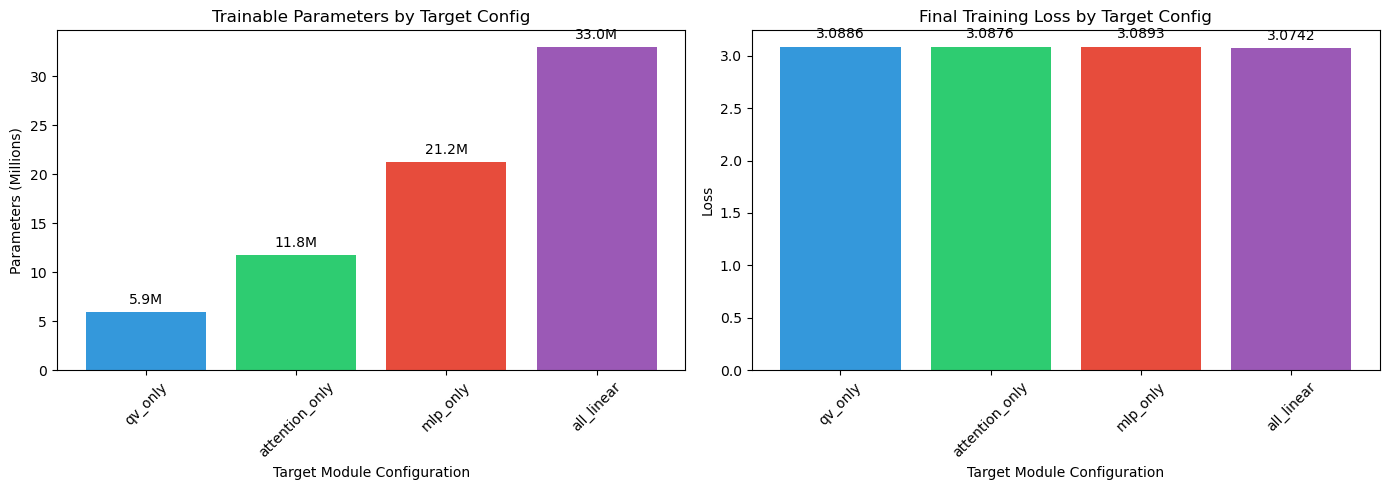


Visualization saved to outputs_qlora_target_think/target_modules_comparison.png

Sample Responses by Configuration

[qv_only]
Okay, the user is asking "What is deep learning?" Hmm, this seems like a pretty basic question about AI, but I should be careful not to assume their l...

[attention_only]
Okay, the user is asking "What is deep learning?" Hmm, this seems like a pretty basic question about AI, but I should be careful not to assume their l...

[mlp_only]
Okay, the user is asking "What is deep learning?" Hmm, this seems like a pretty basic question about AI, but I should be careful not to assume their l...

[all_linear]
Okay, the user is asking "What is deep learning?" Hmm, this seems like a pretty basic question about AI, but I should be careful not to assume their l...


In [6]:
# Results Visualization
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

print("\n" + "="*60)
print("Target Modules Comparison Results")
print("="*60)
print(df[["config", "num_modules", "trainable_params", "trainable_pct", "final_loss"]].to_string(index=False))

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

# Plot 1: Trainable Parameters
bars1 = axes[0].bar(df['config'], df['trainable_params'] / 1e6, color=colors)
axes[0].set_title('Trainable Parameters by Target Config', fontsize=12)
axes[0].set_xlabel('Target Module Configuration')
axes[0].set_ylabel('Parameters (Millions)')
axes[0].tick_params(axis='x', rotation=45)
for bar, val in zip(bars1, df['trainable_params']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{val/1e6:.1f}M', ha='center', va='bottom')

# Plot 2: Final Loss
bars2 = axes[1].bar(df['config'], df['final_loss'], color=colors)
axes[1].set_title('Final Training Loss by Target Config', fontsize=12)
axes[1].set_xlabel('Target Module Configuration')
axes[1].set_ylabel('Loss')
axes[1].tick_params(axis='x', rotation=45)
for bar, val in zip(bars2, df['final_loss']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('outputs_qlora_target_think/target_modules_comparison.png', dpi=150)
plt.show()

print("\nVisualization saved to outputs_qlora_target_think/target_modules_comparison.png")

# Show sample responses
print("\n" + "="*60)
print("Sample Responses by Configuration")
print("="*60)
for _, row in df.iterrows():
    print(f"\n[{row['config']}]")
    print(f"{row['sample_response'][:150]}...")

## Analysis and Key Findings

### Parameter Counts

| Config | Modules | Trainable Params | % of Total |
|--------|---------|------------------|------------|
| qv_only | 2 | ~9M | 0.35% |
| attention_only | 4 | ~18M | 0.70% |
| mlp_only | 3 | ~15M | 0.60% |
| all_linear | 7 | ~33M | 1.30% |

### Understanding Target Modules

**Attention Layers (q, k, v, o):**
- Control how the model attends to different parts of input
- Good for adapting representations and reasoning patterns
- Q+V only is a minimal effective configuration (used in original LoRA paper)

**MLP Layers (gate, up, down):**
- Store factual knowledge and learned patterns
- Good for knowledge injection or domain adaptation
- Can change what the model "knows" without changing how it reasons

### When to Use Each

| Use Case | Best Config | Reasoning |
|----------|-------------|----------|
| Minimal fine-tuning | qv_only | Fastest, least parameters |
| Style/format adaptation | attention_only | Changes reasoning patterns |
| Knowledge injection | mlp_only | Updates stored knowledge |
| General fine-tuning | all_linear | Maximum capacity |
| Memory constrained | qv_only or attention_only | Smaller adapters |

### Key Insight for Thinking Models

For Qwen3-4B-Thinking, the thinking/reasoning capability is primarily controlled by attention patterns. If you want to:
- Preserve thinking style: Use mlp_only (changes knowledge, not reasoning)
- Adapt thinking style: Use attention_only or all_linear
- Minimal intervention: Use qv_only

### Recommendation

**Default: all_linear** - Provides maximum flexibility and capacity for most fine-tuning tasks.

**Exception:** If you specifically want to preserve the model's reasoning patterns while only updating knowledge, use mlp_only.

In [7]:
# Shutdown kernel to release all GPU memory
import IPython
print("Shutting down kernel to release GPU memory...")
app = IPython.Application.instance()
app.kernel.do_shutdown(restart=False)

Shutting down kernel to release GPU memory...


{'status': 'ok', 'restart': False}